In [29]:
from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from astropy.time import Time
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord, match_coordinates_sky, Angle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
import sys

#import sqlite3
import os
from io import StringIO
#import csv

#from desispec.io import read_spectra, write_spectra
#from desispec.spectra import Spectra

# Some handy global variables
global db_filename
db_filename = '/global/cfs/cdirs/desi/science/td/daily-search/transients_search.db'
#global exposure_path
#exposure_path = os.environ["DESI_SPECTRO_REDUX"]
global color_band
color_band = "r"
global minDist
minDist = {}
global user_home
user_home = os.environ['HOME']
global cosmo
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

global today
today = Time.now()

In [2]:
# From https://github.com/desihub/timedomain/blob/master/too_ledgers/decam_TAMU_ledgermaker.ipynb
# Function to grab decam data
from bs4 import BeautifulSoup
import json
import requests
def access_decam_data(url, overwrite=False):
    """Download reduced DECam transient data from Texas A&M.
    Cache the data to avoid lengthy and expensive downloads.
    
    Parameters
    ----------
    url : str
        URL for accessing the data.
    overwrite : bool
        Download new data and overwrite the cached data.
        
    Returns
    -------
    decam_transients : pandas.DataFrame
        Table of transient data.
    """
    folders = url.split('/')
    thedate = folders[-1] if len(folders[-1]) > 0 else folders[-2]
    outfile = '{}.csv'.format(thedate)
    
    if os.path.exists(outfile) and not overwrite:
        # Access cached data.
        decam_transients = pd.read_csv(outfile)
    else:
        # Download the DECam data index.
        # A try/except is needed because the datahub SSL certificate isn't playing well with URL requests.
        try:
            decam_dets = requests.get(url, auth=('decam','tamudecam')).text
        except:
            requests.packages.urllib3.disable_warnings(requests.packages.urllib3.exceptions.InsecureRequestWarning)
            decam_dets = requests.get(url, verify=False, auth=('decam','tamudecam')).text
            
        # Convert transient index page into scrapable data using BeautifulSoup.
        soup = BeautifulSoup(decam_dets)
        
        # Loop through transient object summary JSON files indexed in the main transient page.
        # Download the JSONs and dump the info into a Pandas table.
        decam_transients = None
        j = 0

        for a in soup.find_all('a', href=True):
            if 'object-summary.json' in a:
                link = a['href'].replace('./', '')
                summary_url  = url + link        
                summary_text = requests.get(summary_url, verify=False, auth=('decam','tamudecam')).text
                summary_data = json.loads(summary_text)

                j += 1
                #print('Accessing {:3d}  {}'.format(j, summary_url)) # Modified by Matt

                if decam_transients is None:
                    decam_transients = pd.DataFrame(summary_data, index=[0])
                else:
                    decam_transients = pd.concat([decam_transients, pd.DataFrame(summary_data, index=[0])])
                    
        # Cache the data for future access.
        print('Saving output to {}'.format(outfile))
        decam_transients.to_csv(outfile, index=False)
        
    return decam_transients

In [3]:
decam_transients = access_decam_data('https://datahub.geos.tamu.edu:8000/decam/LCData_Legacy/', overwrite = False) # If True, grabs a fresh batch

In [4]:
decam_transients

,ObjectID,RA-OBJECT,DEC-OBJECT,NumberAlerts,MaxSCORE,RA-PSEUDO-HOST,DEC-PSEUDO-HOST,SEP-PSEUDO-HOST,RA-NEIGHBOR-STAR,DEC-NEIGHBOR-STAR,...,Discovery-Round,Discovery-Time,Discovery-Filter,Discovery-Magnitude,Discovery-SNR,Latest-Round,Latest-Time,Latest-Filter,Latest-Magnitude,Latest-SNR
0,A202103221407558m001825,211.982786,-0.306951,12,0.972,211.982614,-0.306946,0.6199,211.983372,-0.306315,...,0,2021-03-22T06:40:19.074,N,22.13,19.2,9,2021-04-18T05:37:55.763,N,22.86,10.2
1,A202103221408139m033502,212.057952,-3.583947,28,0.954,212.057864,-3.583960,0.3199,212.058798,-3.586276,...,0,2021-03-22T08:20:58.209,N,21.78,25.7,23,2021-06-02T06:00:51.873,N,21.82,18.1
2,A202103221408412p002445,212.171737,0.412527,49,0.998,212.171673,0.412394,0.5317,212.174697,0.411566,...,0,2021-03-22T06:36:50.928,S,20.61,36.2,23,2021-06-02T02:59:21.867,S,21.46,33.9
3,A202103221408578m005300,212.241200,-0.883300,2,0.855,212.241200,-0.883400,0.3000,212.239800,-0.884900,...,0,2021-03-22T08:17:30.880,S,22.55,15.5,1,2021-03-24T07:10:51.368,S,22.33,25.6
4,A202103221409059m023156,212.274757,-2.532478,21,0.969,212.274533,-2.532531,0.8290,212.275356,-2.535003,...,0,2021-03-22T08:14:02.747,N,22.27,10.6,18,2021-05-18T03:17:17.544,N,22.99,8.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,T202106021437535m004239,219.473273,-0.710944,6,0.973,219.473277,-0.711253,1.1100,219.473195,-0.714488,...,23,2021-06-02T02:37:33.855,N,21.46,30.6,24,2021-06-05T02:15:30.763,N,21.44,19.8
553,T202106021440559m025615,220.233290,-2.937658,4,0.940,220.233839,-2.935933,6.5148,220.230799,-2.938535,...,23,2021-06-02T05:33:59.097,S,22.14,13.6,23,2021-06-02T05:40:21.261,S,22.36,14.0
554,T202106021442286m035936,220.619578,-3.993391,3,0.935,220.618952,-3.993328,2.2614,220.615993,-3.991748,...,23,2021-06-02T05:33:59.097,N,22.15,22.5,23,2021-06-02T05:36:54.041,N,22.07,10.5
555,T202106021449003p003225,222.251305,0.540528,7,0.984,222.251090,0.540740,1.0845,222.249251,0.544256,...,23,2021-06-02T02:27:20.976,S,21.04,47.1,24,2021-06-05T02:06:24.397,S,21.21,18.4


In [5]:
decam_transients_agn = access_decam_data('https://datahub.geos.tamu.edu:8000/decam/LCData_Legacy_AGN/', overwrite = False) # If True, grabs a fresh batch

In [6]:
decam_transients_agn

,ObjectID,RA-OBJECT,DEC-OBJECT,NumberAlerts,MaxSCORE,RA-PSEUDO-HOST,DEC-PSEUDO-HOST,SEP-PSEUDO-HOST,RA-NEIGHBOR-STAR,DEC-NEIGHBOR-STAR,...,Discovery-Round,Discovery-Time,Discovery-Filter,Discovery-Magnitude,Discovery-SNR,Latest-Round,Latest-Time,Latest-Filter,Latest-Magnitude,Latest-SNR
0,A202103221404296m011600,211.123549,-1.266841,50,0.981,211.123548,-1.266859,0.0642,211.122907,-1.267989,...,0,2021-03-22T08:17:30.880,S,21.45,37.9,23,2021-06-02T04:51:00.441,S,21.64,13.6
1,A202103221406058m014916,211.524494,-1.821258,21,0.998,211.524436,-1.821287,0.2339,211.525688,-1.825669,...,0,2021-03-22T08:14:02.747,N,21.51,17.6,23,2021-06-02T04:51:00.441,N,22.00,8.3
2,A202103221406345m013845,211.643891,-1.645873,48,1.000,211.643853,-1.645901,0.1670,211.643410,-1.644483,...,0,2021-03-22T08:14:02.747,N,20.46,44.2,23,2021-06-02T04:51:00.441,N,20.70,27.4
3,A202103221407026p022639,211.760984,2.444273,59,1.000,211.760994,2.444240,0.1246,211.761842,2.445017,...,0,2021-03-22T06:29:53.254,S,20.59,56.8,23,2021-06-02T06:06:18.723,S,21.71,10.1
4,A202103221407081m012201,211.783988,-1.367098,45,0.972,211.783957,-1.367113,0.1226,211.779238,-1.366661,...,0,2021-03-22T08:14:02.747,S,21.66,16.5,23,2021-06-02T04:51:00.441,S,21.75,12.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,A202105271359059p035119,209.774851,3.855449,3,0.597,209.774820,3.855384,0.2591,209.776087,3.853736,...,21,2021-05-27T02:36:40.649,N,22.52,9.8,22,2021-05-30T04:41:05.106,N,22.34,14.0
401,A202105301422044p012434,215.518658,1.409499,6,0.881,215.518710,1.409507,0.1869,215.519990,1.409375,...,22,2021-05-30T04:52:45.978,N,22.01,8.5,23,2021-06-02T06:08:56.302,N,21.79,13.0
402,A202106021410416p001347,212.673701,0.229749,3,0.929,212.673677,0.229739,0.0931,212.673947,0.228041,...,23,2021-06-02T02:58:03.131,S,21.13,72.9,23,2021-06-02T03:01:02.221,S,21.76,12.1
403,A202106021446189m013323,221.579034,-1.556427,2,0.450,221.578953,-1.556425,0.2892,221.580610,-1.556967,...,23,2021-06-02T05:18:39.435,S,22.52,9.4,23,2021-06-02T05:19:58.553,S,22.71,11.0


In [7]:
# Read useful data from fits file, RA, DEC, target ID, and mjd as a leftover from previous use 
def read_fits_info(filepath: str, transient_candidate = False):
    
    if transient_candidate:
        hdu_num = 1
    else:
        hdu_num = 5
    
    try:
        with fits.open(filepath) as hdu1:
    
            data_table = Table(hdu1[hdu_num].data) #columns
        
            targ_ID = data_table['TARGETID']
            targ_ra = data_table['TARGET_RA'].data # Now it's a numpy array
            targ_dec = data_table['TARGET_DEC'].data
            targ_z = data_table['Z'].data
            targ_label = data_table['CNNLABEL']
            
            #targ_mjd = data_table['MJD'][0] some have different versions of this so this is a *bad* idea... at least now I know the try except works!
            
            # if transient_candidate: 
            #     targ_mjd = hdu1[hdu_num].header['MJD-OBS'] # This is a string
            # else:
            #     targ_mjd = data_table['MJD'].data
            #     targ_mjd = Time(targ_mjd[0], format = 'mjd')
            
    except:
        filename = filepath.split("/")[-1]
        print("Could not open or use:", filename)
        #print("In path:", filepath)
        #print("Trying the next file...")
        return np.array([]), np.array([]), np.array([]), np.array([])
    
    return targ_ra, targ_dec, targ_ID, targ_z, targ_label #targ_mjd, targ_ID

In [8]:
trans_ra, trans_dec, trans_id, trans_z, trans_label = read_fits_info(user_home + "/DECam_transient_spectra.fits", True)

In [9]:
print(len(trans_id))

419


In [10]:
# Convert df RA/DEC to numpy arrays
decam_id = decam_transients["ObjectID"].to_numpy()
decam_ra = decam_transients["RA-OBJECT"].to_numpy()
decam_dec = decam_transients["DEC-OBJECT"].to_numpy()

trans_id = np.array(trans_id)
#trans_ra = np.array(trans_ra)
#trans_dec = np.array(trans_dec)

# Convert everything to SkyCoord
trans_coord = SkyCoord(trans_ra*u.deg, trans_dec*u.deg)
decam_coord = SkyCoord(decam_ra*u.deg, decam_dec*u.deg)

# Do the matching! 
idx_decam, d2d_trans, d3d_trans = match_coordinates_sky(trans_coord, decam_coord)

In [11]:
max_sep = 2*u.arcsec
# Filter out the good stuff
sep_constraint = d2d_trans < max_sep
trans_matches = trans_coord[sep_constraint]

trans_matches_ids = trans_id[sep_constraint]
trans_matches_zs = trans_z[sep_constraint]
trans_matches_labels = trans_label[sep_constraint]

decam_matches = decam_coord[idx_decam[sep_constraint]]
decam_matches_ids = decam_id[idx_decam[sep_constraint]]

In [12]:
assert len(decam_matches) == len(trans_id) # Just in case something crazy happened

In [13]:
# From https://github.com/desihub/timedomain/blob/master/too_ledgers/decam_TAMU_ledgermaker.ipynb
# Function to grab decam csvs, modified from above
def access_decam_csvs(url, decam_ids, trans_zs, *args): 
    """Download reduced DECam transient data from Texas A&M.
    Cache the data to avoid lengthy and expensive downloads.
    
    Parameters
    ----------
    url : str
        URL for accessing the data.
    decam_ids : numpy array
        Array of matched (to DESI obs) DECam IDs
    trans_zs  : numpy array
        Necessary for removing bad z data to correlate with output
    args      : numpy arrays
        Using for arbitrary number of appends onto end of resulting
        numpy array in case I need to retain more information with
        the different reduction/selection steps
        
    Returns
    -------
    appMagMax_dict : dictionary (keys = "z", "g", "r")
        Array of information for each target, 
        selected at peak magnitude for each set of observations
        mjd, filter, mag, magerr, lm5, sciname, alert, z, *args
    """
    
    appMagMax_dict = {"z":None, "g": None, "r": None}     
    
    for dID, z, idx in zip(decam_ids, trans_zs, range(len(decam_ids))):        
        filename = '/'.join((url + dID, "lc_" + dID + ".csv"))
        
        csv_retrieve = requests.get(filename, verify=False, auth=('decam', 'tamudecam')) #, stream=True)
        csv_content = csv_retrieve.content
        csv_arr = csv_content.decode("utf-8")
        
        with StringIO(csv_arr) as c:
            df = pd.read_csv(c)
          
        df_np = df.to_numpy()
        #z_array = np.full((len(df_np), 1), z)
        #df_np = np.concatenate((df_np, z_array), axis = 1)
        
        condition = (df_np[:, 2] + 2*df_np[:, 3]) < df_np[:, 4] #& df_np[:, -1] > 0
        data_masked = df_np[condition]
        
        z_appMag = data_masked[data_masked[:, 1] == "z"]
        g_appMag = data_masked[data_masked[:, 1] == "g"]
        r_appMag = data_masked[data_masked[:, 1] == "r"]
        
        temp_list = [z_appMag, g_appMag, r_appMag]
        
        for i, j in zip(temp_list, "zgr"):
            try:
                argmax_mag = np.argmin(i[:,2])
            except:
                continue
            
            row = np.append(i[argmax_mag,:], z)
            
            if args:
                for arg in args:
                    row = np.append(row, arg[idx])
            
            if not np.any(appMagMax_dict[j]):
                appMagMax_dict[j] = row
            else:
                appMagMax_dict[j] = np.vstack((appMagMax_dict[j], row))
        
        #argmax_mag = np.argmin(data_masked[:, 2])
        # try:
        #    all_max_mag = np.vstack((all_max_mag, data_masked[argmax_mag,:])) 
        # except:
        #    all_max_mag = data_masked[argmax_mag,:]

    #print(csv_info)
    return appMagMax_dict

In [14]:
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
apparent_mag_maxes = access_decam_csvs('https://datahub.geos.tamu.edu:8000/decam/LCData_Legacy/', decam_matches_ids, trans_matches_zs,
                                       trans_matches_ids, trans_matches_labels)

In [15]:
z_appMag_maxes = apparent_mag_maxes["z"]
g_appMag_maxes = apparent_mag_maxes["g"]
r_appMag_maxes = apparent_mag_maxes["r"]
all_appMag_maxes = [z_appMag_maxes, g_appMag_maxes, r_appMag_maxes]

In [16]:
#print(apparent_mag_max[:, 2:5])
print(np.shape(z_appMag_maxes))
print(np.shape(g_appMag_maxes))
print(np.shape(r_appMag_maxes))

(392, 10)
(286, 10)
(395, 10)


In [37]:
def calculate_absMag(appMag_in):
    # They don't give us an absolute magnitude so we calculate our own using redshifts from REDROCK
    zDistances = cosmo.luminosity_distance(appMag_in[:, 7]).to(u.pc)
    
    # There are some negative distances, likely due to error in redshift measurement
    condition = zDistances > 0
    KN_condition = appMag_in[:, 9] == "KN"
    
    appMag_reduced = appMag_in[condition]
    zDist_reduced = zDistances[condition]
    
    KN_appMag_reduced = appMag_in[KN_condition & condition]
    KN_zDist_reduced = zDistances[KN_condition & condition]
    
    # M = m - 5log(d/10pc) + 5
    absMags = appMag_reduced[:, 2] - 5*np.log10(0.1*zDist_reduced.astype(float)/u.pc) + 5
    KN_absMags = KN_appMag_reduced[:, 2] - 5*np.log10(0.1*KN_zDist_reduced.astype(float)/u.pc) + 5
    
    # Return both so we can reduce the other arrays as well by z_distances
    return [appMag_reduced[:,2], absMags], [KN_appMag_reduced[:,2], KN_absMags], appMag_reduced

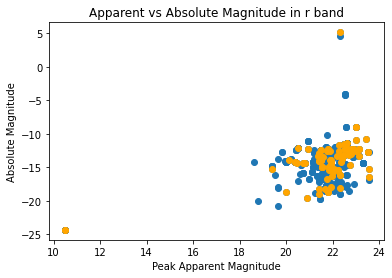

In [41]:
# index 8 = transient IDs
# index 9 = CNN labels

# TODO: Ask for cutoff values and create arrays to hold them for tabling later
# high_absMag = []
# low_appMag = []

for i, f in zip(all_appMag_maxes, "zgr"):
    all_candidates, KN_candidates, appMagMaxes_reduced = calculate_absMag(i)
    
    plt.clf()
    plt.scatter(*all_candidates)
    plt.scatter(*KN_candidates, color = 'orange')
    
    plt.xlabel("Peak Apparent Magnitude")
    plt.ylabel("Absolute Magnitude")
    plt.title("Apparent vs Absolute Magnitude in " + f + " band")
    plt.savefig(user_home + "/mag_plots/absMag-vs-peakAppMag_" + f + ".png")